## EAEEE4000_001_Final Project_Second Model Code --- Using Random Forest
#### Name: Jiuhe(Rebecca) Shi (UNI: js6112)
#### Project Title: Prediction of Ocen Partial Pressure of CO2 (pCO2)  by Using XGBoost, Random Forest and LSTM
#### Date: December, 2022

### Random Forest Introduction 

As a supervised machine learning algorithm, random forest is widely used in classification and regression problems. For different samples, the decision tree constructed will vote on the classification and average value to determine. In the working process of the algorithm, there will be the case of ensembling multiple models, so integration can be divided into two types, Bagging and Boosting. The first model in my project is the XGboost, which is the Boosting ensemble model based on the decision tree. Random forest is another type, Bagging ensemble. The schematic of the random forest is described below and is basically divided into four steps. First divide the data set, randomly record, build a separate decision tree, produce output based on the average of the vote or regression to consider the results.

Reference - [`Random-Forest` ](https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/).
![RF](images/RF_Principle.jpg)

### Load all packages used in this project

In [1]:
# packages used in this tutorial 
import joblib
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import datetime
import pandas as pd
# RandomForestRegressor Model
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# evaluation metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# using graphviz to plot RF trees
from sklearn.tree import export_graphviz
from sklearn import tree
from utils import * 
from dtreeviz.trees import *
%config InlineBackend.figure_format = 'retina'

### Open & Clean Dataset

In [2]:
data = xr.open_dataset('/Users/rebecca/Downloads/MERGED-DATA_1x1_mon_198201-202112.nc')
data = data.sel(time=slice('1982', '2021')).load()
data_pd = data.to_dataframe()
data

<xarray.Dataset>
Dimensions:         (time: 480, lat: 180, lon: 360)
Coordinates:
  * lon             (lon) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat             (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time            (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2021-12-15
Data variables:
    fco2_ave_unwtd  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    mld             (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    chl             (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    mask            (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    sss             (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    sst             (time, lat, lon) float64 nan nan nan ... -1.732 -1.738 -1.75
    atm_pco2_uatm   (time, lat, lon) float64 331.2 331.2 331.2 ... 404.9 404.9

In [3]:
data_clean = data_pd[data_pd['fco2_ave_unwtd'].notnull() & data_pd['mld'].notnull() & data_pd['chl'].notnull()
                    & data_pd['mask'].notnull() & data_pd['sss'].notnull() & data_pd['sst'].notnull() 
                     & data_pd['atm_pco2_uatm'].notnull()]
data_clean

fco2_ave_unwtd         mld       chl  mask        sss  \
time       lat   lon                                                            
1982-01-15 -0.5  137.5      320.476288   34.367130  0.213072   1.0  34.227975   
            0.5  137.5      336.389130   33.478939  0.130572   1.0  34.261681   
            1.5  137.5      342.459686   39.543957  0.126997   1.0  34.302076   
            2.5  136.5      343.751190   23.772850  0.133725   1.0  34.300365   
                 137.5      344.493958   45.244648  0.128011   1.0  34.309180   
...                                ...         ...       ...   ...        ...   
2021-12-15  44.5 334.5      377.762512  129.950058  0.180022   1.0  35.823172   
                 341.5      382.966675  109.925339  0.469160   1.0  35.762420   
                 342.5      386.497375   84.819145  0.402202   1.0  35.757088   
            45.5 348.5      395.024994  102.078323  0.617956   1.0  35.662514   
            46.5 350.5      396.402771  100.040131  0.241002   1.0  35.623573   

                              sst  atm_pco2_uatm  
time       lat   lon                              
1982-01-15 -0.5  137.5  29.022418     331.245001  
            0.5  137.5  29.269918     331.245001  
            1.5  137.5  29.666697     331.245001  
            2.5  136.5  29.420000     331.245001  
                 137.5  29.702498     331.245001  
...                           ...            ...  
2021-12-15  44.5 334.5  16.412507     404.900235  
                 341.5  15.100598     404.900235  
                 342.5  15.084283     404.900235  
            45.5 348.5  14.092825     404.900235  
            46.5 350.5  13.716935     404.900235  

[252850 rows x 7 columns]

### Split Data into Training and Testing

In [4]:
# Import train_test_split function
X, Y = data_clean.iloc[:,:-1],data_clean.iloc[:,-1]
# Split dataset into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1,random_state = 42)
# 90% training and 10% test

### Random Forest Model Building and Training 

In [5]:
%%time
# Create the Regression
model = RandomForestRegressor(n_estimators=13,
                              # the number of decision trees
                          max_features = 'sqrt', 
                              # max number of features the model will consider when determining a split
                              # squared root of the number of parameters in our training dataset.
                          max_depth = 23, 
                              # maxi possible depth of each tree
                          random_state = 42, 
                              # keep everything standard
                          #min_samples_leaf = 2, 
                          #min_samples_split = 2
                             )

#Train the model using the training sets Y_pred=clf.predict(X_test)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
Y_pred_train = model.predict(X_train)

CPU times: user 5.57 s, sys: 117 ms, total: 5.69 s
Wall time: 5.69 s


### Save & Load Model  

In [6]:
now = datetime.now()
timestamp = now.strftime("%m-%d-%Y-%H:%M:%S")
joblib.dump(model, "best_model/random_forest-{}.joblib".format(timestamp))

# load model
# loaded_model = joblib.load("./random_forest-{}.joblib")

['best_model/random_forest-12-23-2022-16:25:29.joblib']

### Evaluation Matrix Data

In [7]:
# Mean Absolute Error, Mean Square Error, Root Mean Square Error
MAE = mean_absolute_error(Y_test,Y_pred)
print('MAE:',metrics.mean_absolute_error(Y_test,Y_pred))

MSE = mean_squared_error(Y_test, Y_pred)
print(f'MSE: {MSE}')

RMSE = np.sqrt(mean_squared_error(Y_test, Y_pred))
print("RMSE: %f" % (RMSE))

MAE: 8.463449331862238
MSE: 123.87901814324192
RMSE: 11.130095


### Relationship Between Predicted Values & True Values 

### Y_test vs. Y_pred

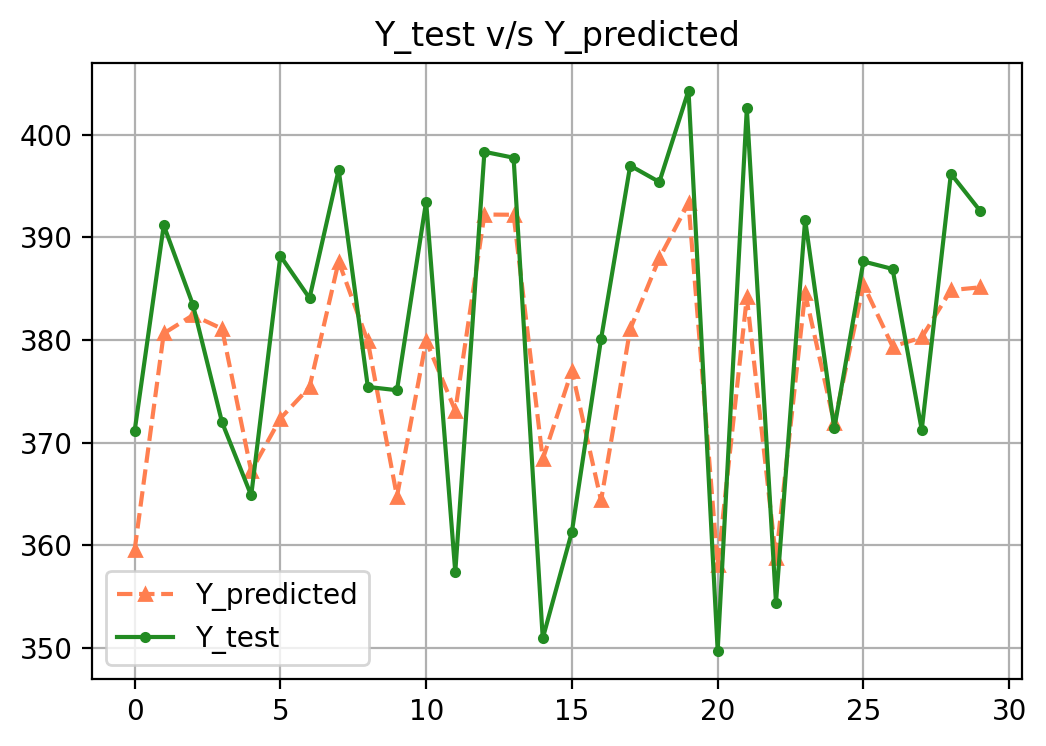

In [8]:
Y_pred = model.predict(X_test)
plt.figure(figsize=(6, 4))
## give the first 20th data in details in order to see the performance of prrdiction
## The amount of whole data is huge
plt.plot(Y_pred[:30,], label='Y_predicted',  marker= '^', 
         markersize=4, color= 'coral',
         linestyle='--')
plt.plot(Y_test.values[:30,], label='Y_test', marker= '.', color= 'forestgreen')
plt.title("Y_test v/s Y_predicted")
plt.grid()
plt.legend()
plt.show()

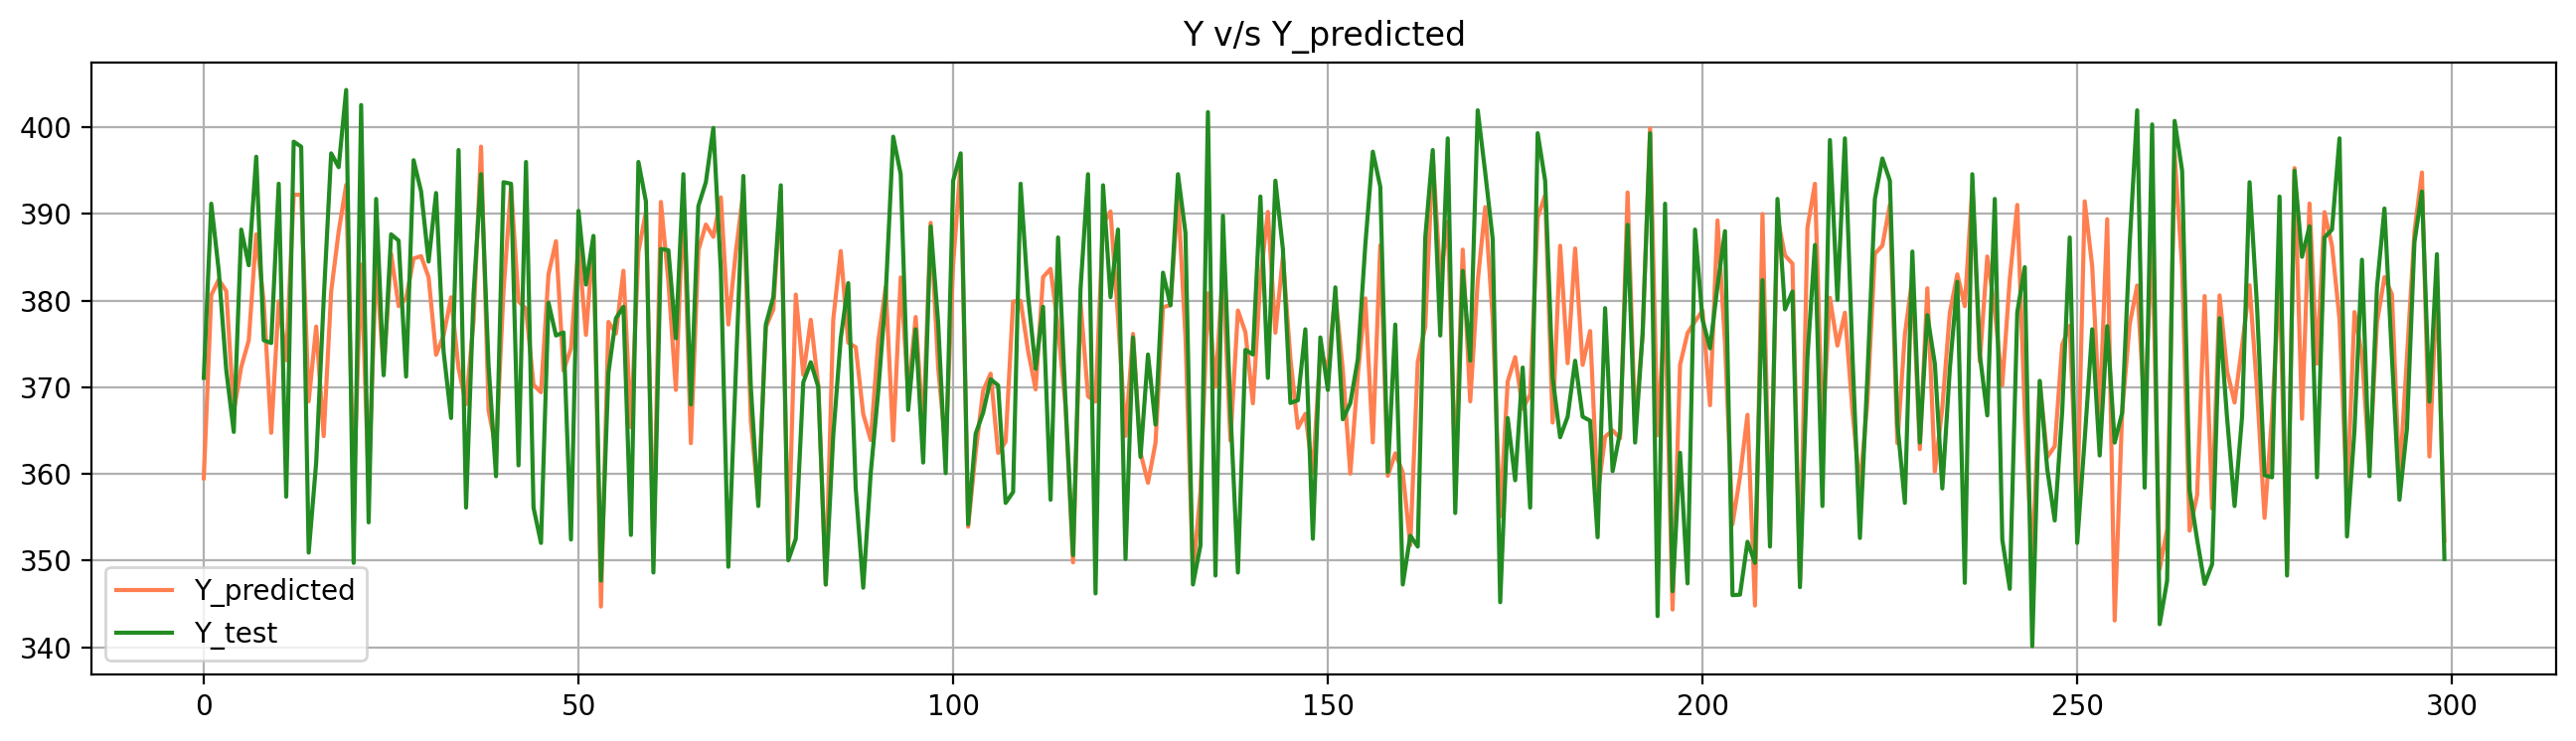

In [11]:
Y_pred = model.predict(X_test)
plt.figure(figsize=(16, 4))
plt.plot(Y_pred[:300,], label='Y_predicted', color= 'coral')
plt.plot(Y_test.values[:300,], label='Y_test',  color= 'forestgreen')
plt.title("Y v/s Y_predicted")
plt.grid()
plt.legend()
plt.show()

### Y_train vs. Y_pred_train

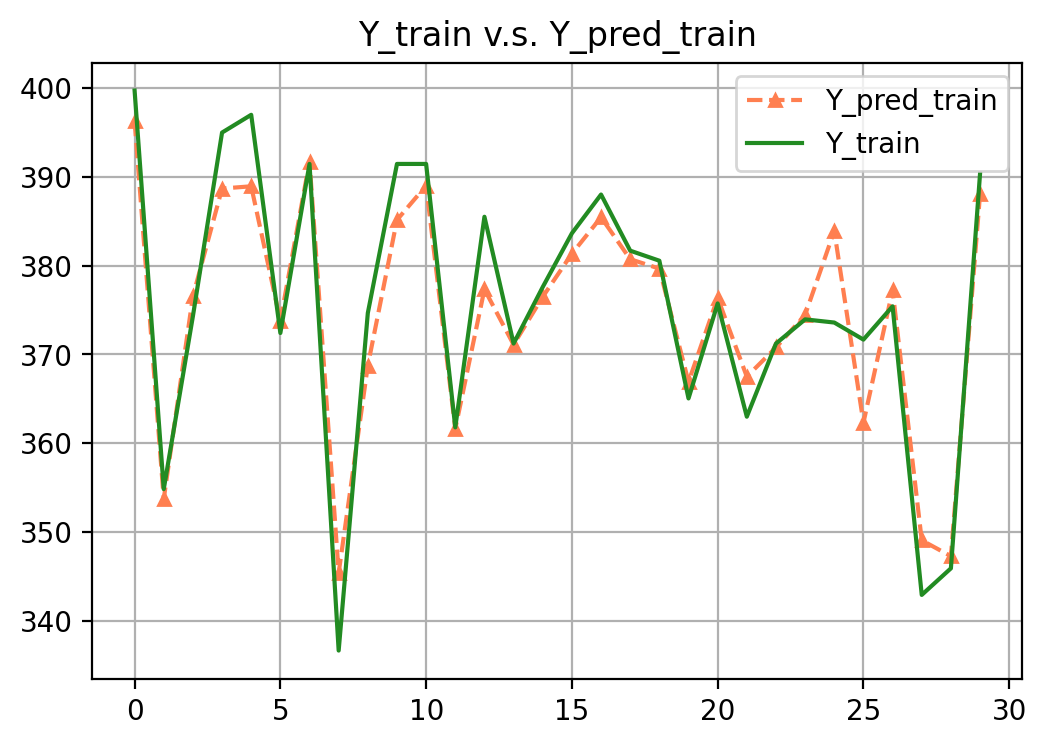

In [12]:
Y_pred_train = model.predict(X_train)
plt.figure(figsize=(6, 4))
plt.plot(Y_pred_train[:30,], label='Y_pred_train',  marker= '^', markersize=4, color= 'coral', linestyle='--')
plt.plot(Y_train.values[:30,], label='Y_train', color= 'forestgreen')
plt.title("Y_train v.s. Y_pred_train")
plt.grid()
plt.legend()
plt.show()

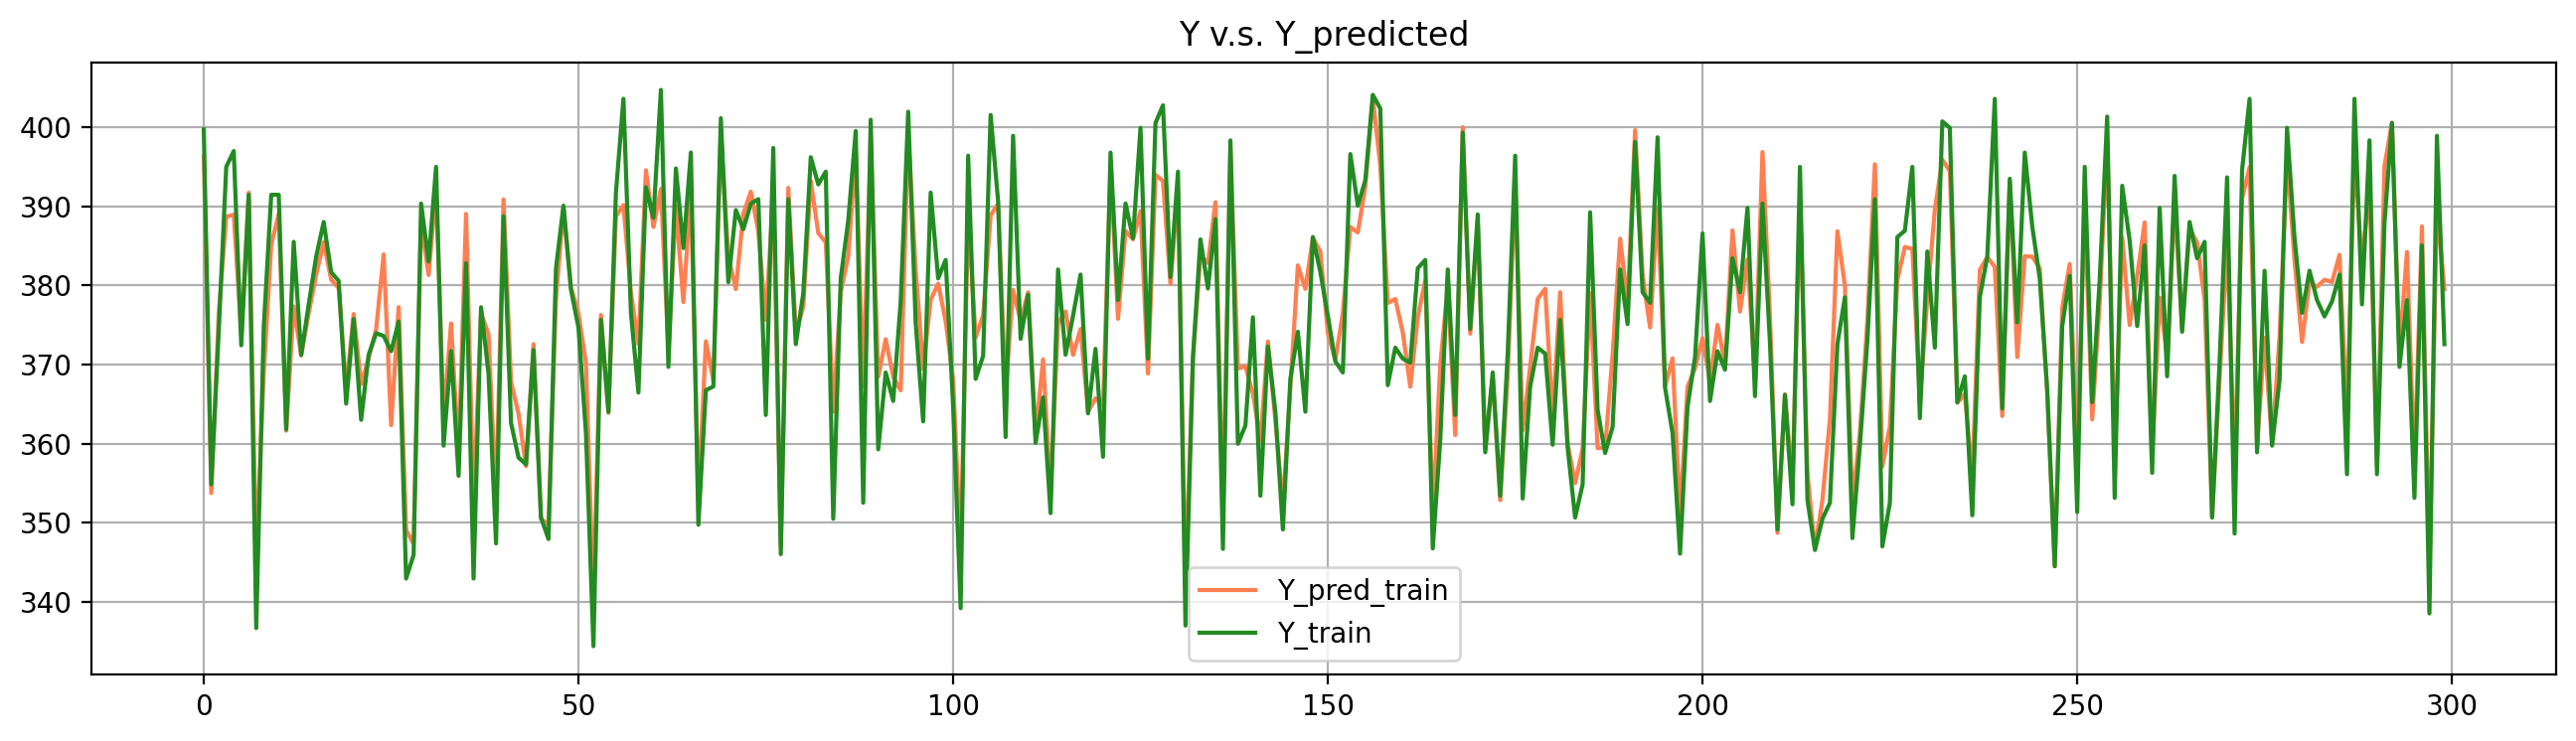

In [13]:
Y_pred_train = model.predict(X_train)
plt.figure(figsize=(16, 4))
plt.plot(Y_pred_train[:300,], label='Y_pred_train', color= 'coral')
plt.plot(Y_train.values[:300,], label='Y_train', color= 'forestgreen')
plt.title("Y v.s. Y_predicted")
plt.grid()
plt.legend()
plt.show()

### Feature Importance

Text(0.5, 0, 'Random Forest Feature Importance')

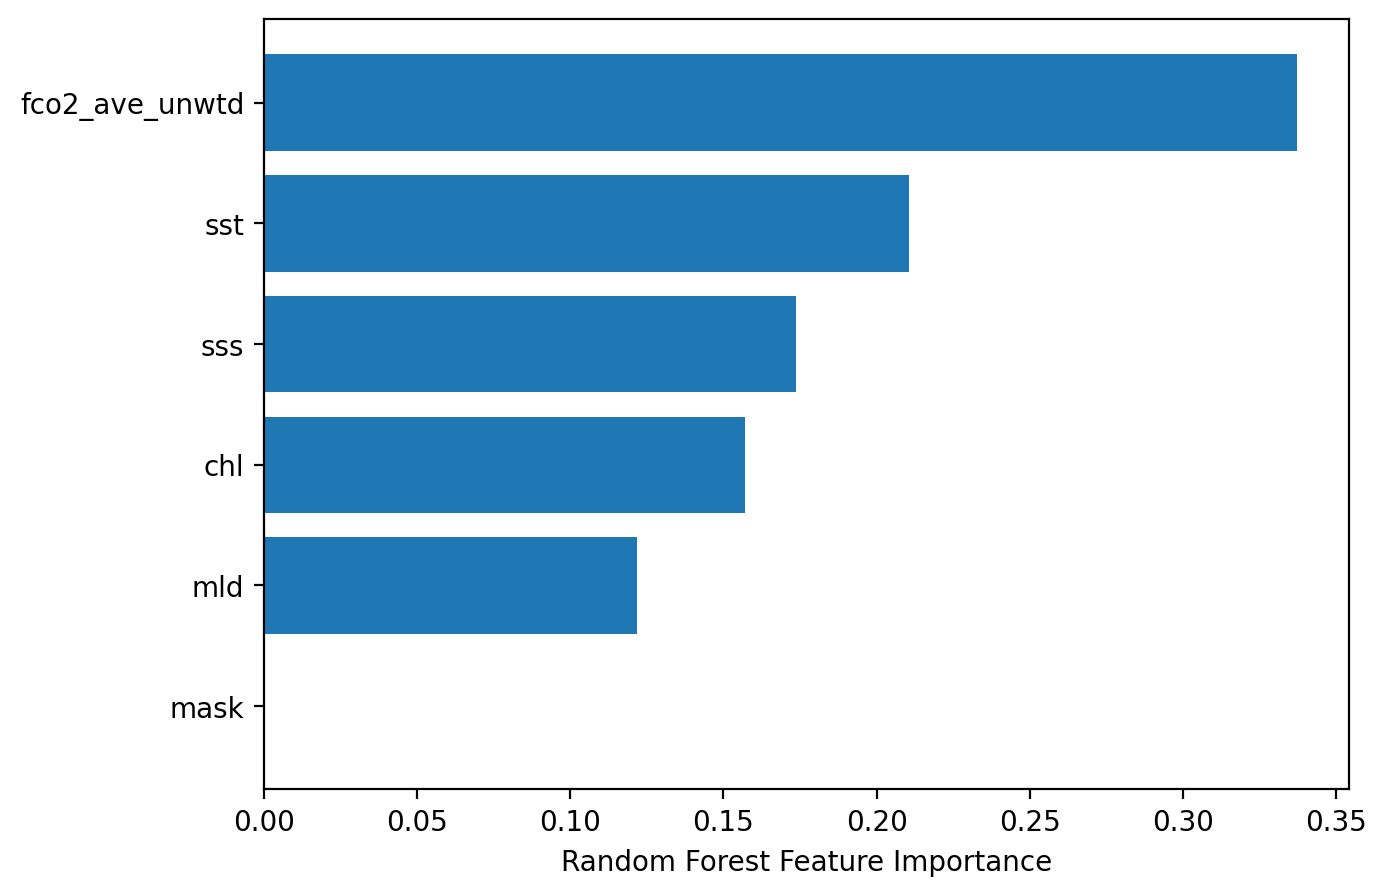

In [14]:
model.feature_importances_
sorted_idx = model.feature_importances_.argsort()
plt.rcParams['figure.figsize'] = [7, 5]
plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Loss Function Analysis 

I trained multiple times on my Random Forest models with two main parameters, n_estimators and max_depth in order to decrease the RMSE result. The following two figures are the loss function figure of the random forest model.

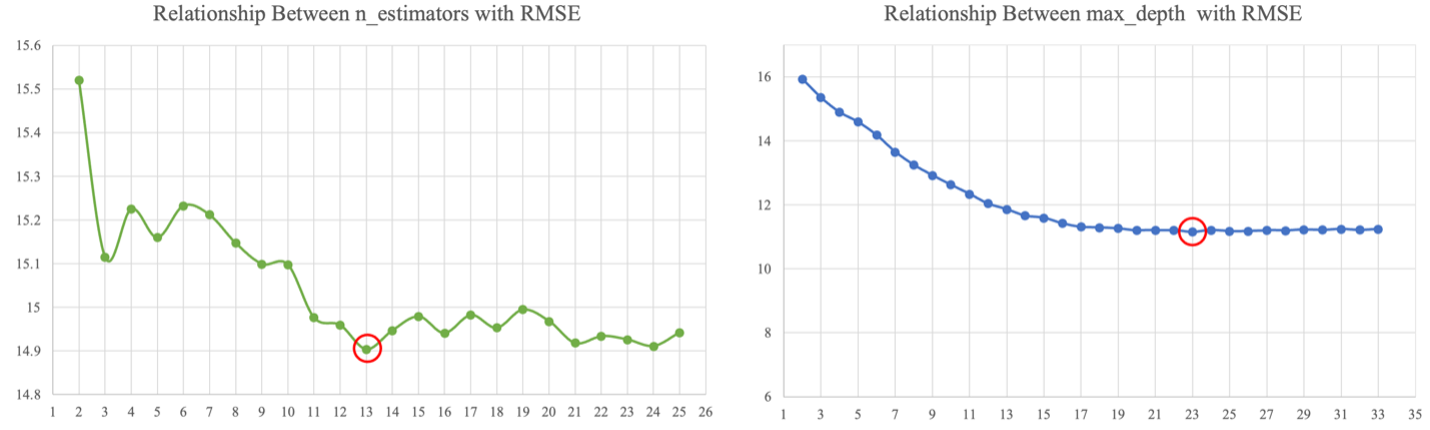

### Plot RF Trees

In [16]:
estimator = model.estimators_[0]
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = "atm_pco2_uatm",
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [ ]:
# Convert to svg using system command (Using Graphviz)
from subprocess import call
call(['dot', '-Tsvg', 'tree.dot', '-o', 'tree.svg'])

from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM
drawing = svg2rlg("tree.svg")
renderPDF.drawToFile(drawing, "tree.pdf")
renderPM.drawToFile(drawing, "tree.png", fmt="PNG")

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

### Appendix. Details for the Training RF Model Parameters

In [ ]:
# # Build the RandomForestRegressor
# model = RandomForestRegressor(
#     n_estimators=1,# the number of decision trees
#     max_features = 'sqrt', # max number of features the model will consider when determining a split
#     # squared root of the number of parameters in our training dataset.
#     max_depth = 3, # maxi possible depth of each tree
#     random_state = 42, # keep everything standard
#     min_samples_leaf = 2, 
#     min_samples_split = 2
#                              )

# # Train the model using the training sets Y_pred=model.predict(X_test)
# model.fit(X_train,Y_train)